In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# Define the U-Net architecture
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2)
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.middle(x1)
        x3 = self.decoder(x2)
        return x3


In [ ]:
# Define a custom dataset
class DepthDataset(Dataset):
    def __init__(self, rgb_paths, depth_paths, transform=None, output_size=None):
        self.rgb_paths = rgb_paths
        self.depth_paths = depth_paths
        self.transform = transform
        self.output_size = output_size

    def __len__(self):
        return len(self.rgb_paths)

    def __getitem__(self, idx):
        rgb = Image.open(self.rgb_paths[idx]).convert('RGB')
        depth = Image.open(self.depth_paths[idx]).convert('L')

        if self.output_size:
            depth = depth.resize(self.output_size, Image.ANTIALIAS)

        if self.transform:
            rgb = self.transform(rgb)

        return rgb, depth

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Set device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Define hyperparameters
batch_size = 8
learning_rate = 0.001
num_epochs = 100

In [ ]:
# Define paths to your RGB and depth images
rgb_dir = '/content/drive/MyDrive/child_data/rgb'
depth_dir = '/content/drive/MyDrive/child_data/depth'

In [ ]:
import os

# Create a list of RGB and depth image paths
rgb_paths = [f'{rgb_dir}/{filename}' for filename in os.listdir(rgb_dir)]
depth_paths = [f'{depth_dir}/{filename}' for filename in os.listdir(depth_dir)]

In [ ]:
# Define a transform to convert PIL images to tensors
transform = ToTensor()

# Define a custom collate function to convert PIL images to tensors
def custom_collate(batch):
    rgb_batch = []
    depth_batch = []

    for rgb, depth in batch:
        if isinstance(rgb, torch.Tensor):
            rgb_batch.append(rgb)
        else:
            rgb_batch.append(transform(rgb))

        if isinstance(depth, torch.Tensor):
            depth_batch.append(depth)
        else:
            depth_batch.append(transform(depth))

    rgb_batch = torch.stack(rgb_batch)
    depth_batch = torch.stack(depth_batch)

    return rgb_batch, depth_batch


# Create a custom dataset
dataset = DepthDataset(rgb_paths, depth_paths, transform=transform)

In [ ]:
# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [ ]:
# Create data loaders with the custom collate function
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=custom_collate)

# Initialize the U-Net model
model = UNet(in_channels=3, out_channels=1).to(device)

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
import torch

# Define calculate mse function to calculate mean squared error
def calculate_mse(output, target):
    return torch.mean((output - target) ** 2)


Epoch [1/100], Train Loss: 0.3094
Epoch [1/100], MSE: 0.0116
Epoch [2/100], Train Loss: 0.0094
Epoch [2/100], MSE: 0.0057
Epoch [3/100], Train Loss: 0.0062
Epoch [3/100], MSE: 0.0050
Epoch [4/100], Train Loss: 0.0061
Epoch [4/100], MSE: 0.0057
Epoch [5/100], Train Loss: 0.0058
Epoch [5/100], MSE: 0.0048
Epoch [6/100], Train Loss: 0.0058
Epoch [6/100], MSE: 0.0046
Epoch [7/100], Train Loss: 0.0060
Epoch [7/100], MSE: 0.0056
Epoch [8/100], Train Loss: 0.0058
Epoch [8/100], MSE: 0.0048
Epoch [9/100], Train Loss: 0.0060
Epoch [9/100], MSE: 0.0045
Epoch [10/100], Train Loss: 0.0057
Epoch [10/100], MSE: 0.0045
Epoch [11/100], Train Loss: 0.0059
Epoch [11/100], MSE: 0.0049
Epoch [12/100], Train Loss: 0.0059
Epoch [12/100], MSE: 0.0043
Epoch [13/100], Train Loss: 0.0054
Epoch [13/100], MSE: 0.0043
Epoch [14/100], Train Loss: 0.0060
Epoch [14/100], MSE: 0.0042
Epoch [15/100], Train Loss: 0.0057
Epoch [15/100], MSE: 0.0044
Epoch [16/100], Train Loss: 0.0052
Epoch [16/100], MSE: 0.0051
Epoch [17/

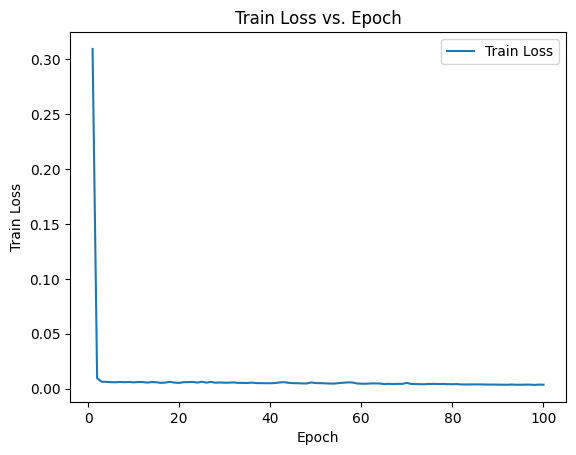

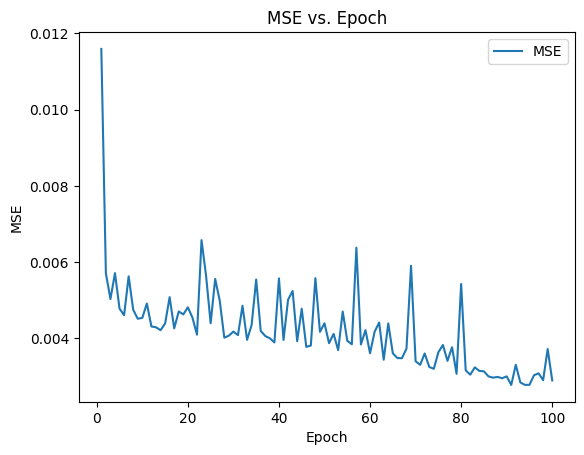

In [ ]:
train_losses = []
val_mses = []

# Training loop
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()

    train_loss = 0.0

    for rgb, depth in train_loader:
        # Move data to the device (GPU if available)
        rgb = rgb.to(device)
        depth = depth.to(device)

        # Forward pass
        output = model(rgb)

        # Resize output tensor to match the size of the target tensor
        output = nn.functional.interpolate(output, size=depth.shape[2:], mode='bilinear', align_corners=False)

        # Calculate the loss
        loss = criterion(output, depth)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item() * rgb.size(0)

    # Calculate average training loss
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}')

    # Validation
    model.eval()

    val_loss = 0.0
    val_mse = 0.0
    val_ssim = 0.0
    total_samples = 0

    with torch.no_grad():
        for rgb_val, depth_val in val_loader:
            rgb_val = rgb_val.to(device)
            depth_val = depth_val.to(device)

            val_output = model(rgb_val)

            # Resize output tensor to match the size of the target tensor
            val_output = nn.functional.interpolate(val_output, size=depth_val.shape[2:], mode='bilinear', align_corners=False)

            # Calculate the loss
            val_loss += criterion(val_output, depth_val).item() * rgb_val.size(0)

            # Calculate the MSE
            val_mse += calculate_mse(val_output, depth_val) * rgb_val.size(0)

            total_samples += rgb_val.size(0)

    # Calculate average validation loss, MSE, and SSIM
    val_loss /= len(val_loader.dataset)
    val_mse /= total_samples
    val_mses.append(val_mse)

    # Print results
    print(f'Epoch [{epoch+1}/{num_epochs}], MSE: {val_mse:.4f}')

# Move val_mses to CPU
val_mses = [mse.cpu().numpy() for mse in val_mses]

# Plotting the graphs
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss vs. Epoch')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, num_epochs + 1), val_mses, label='MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE vs. Epoch')
plt.legend()
plt.show()


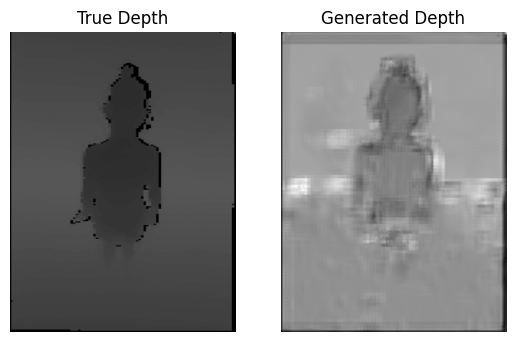

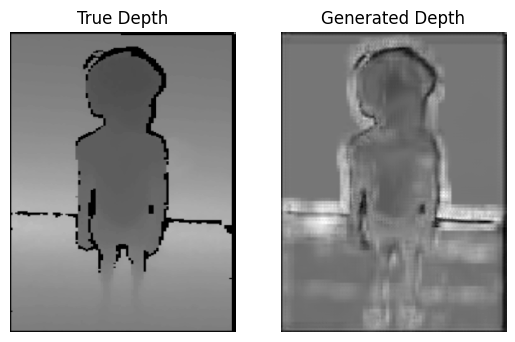

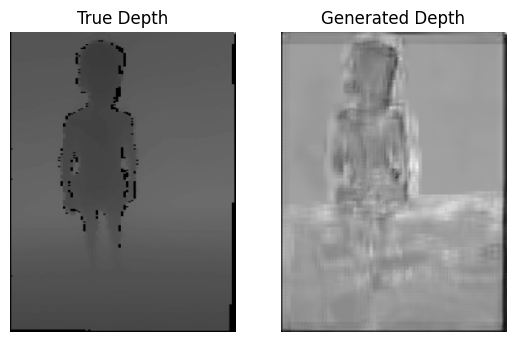

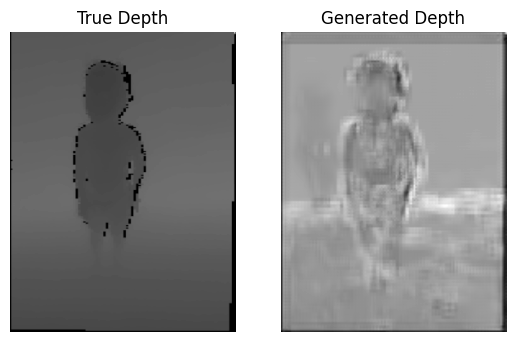

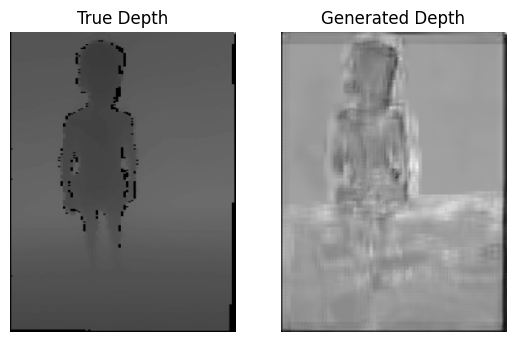

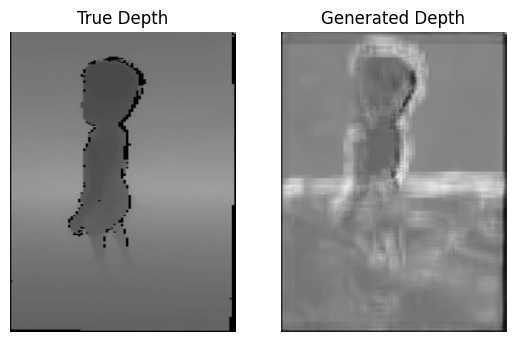

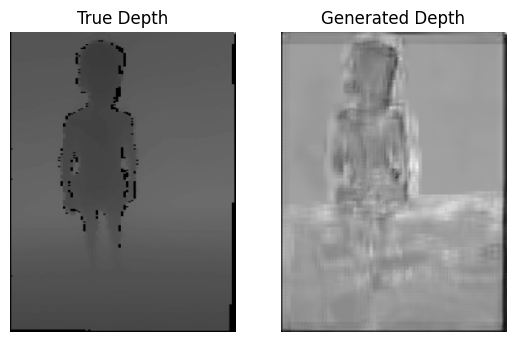

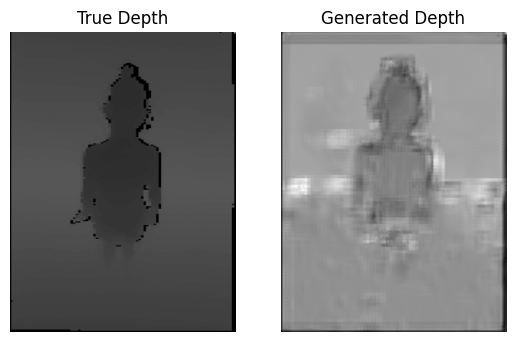

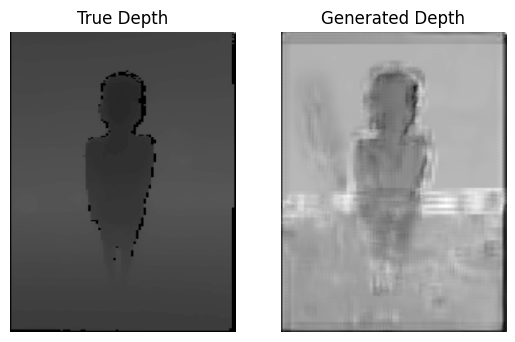

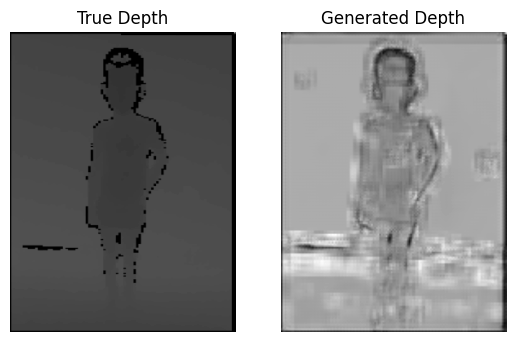

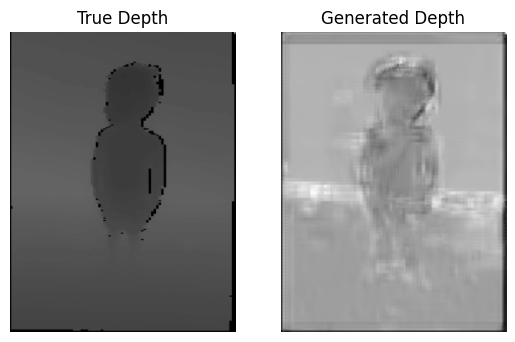

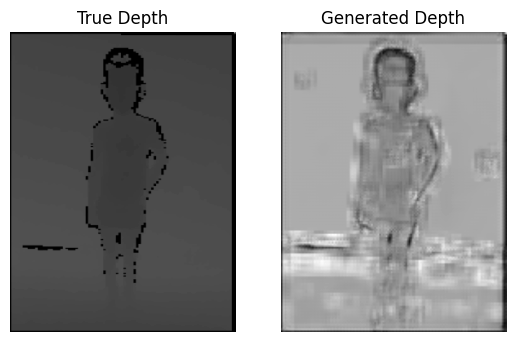

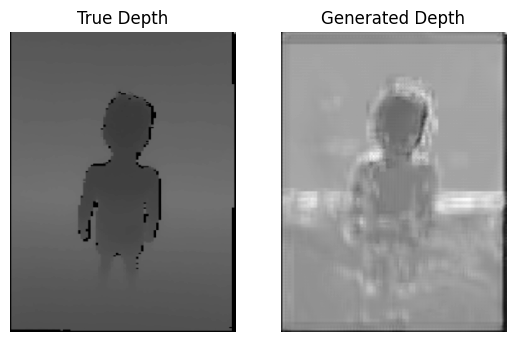

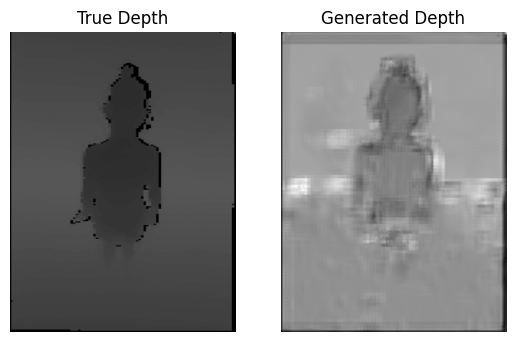

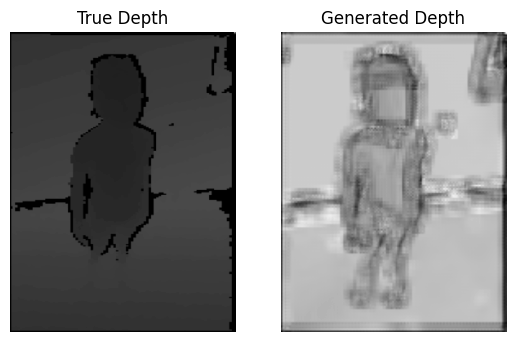

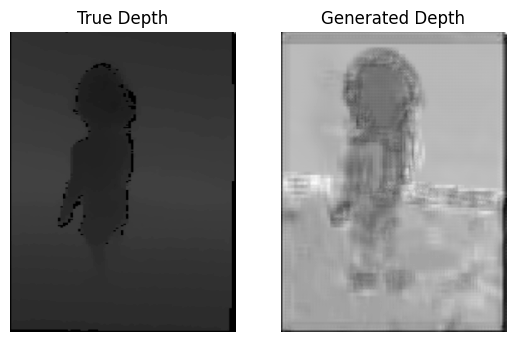

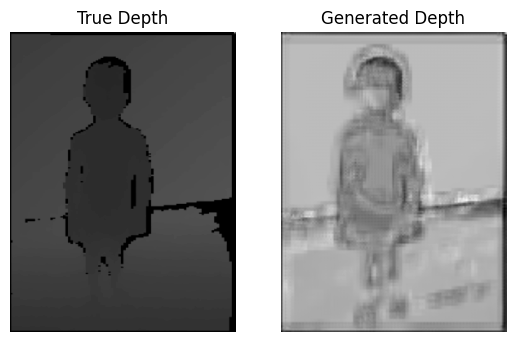

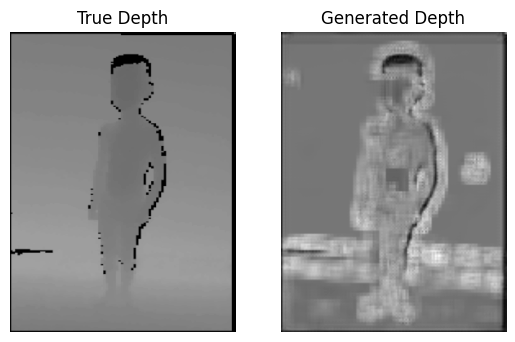

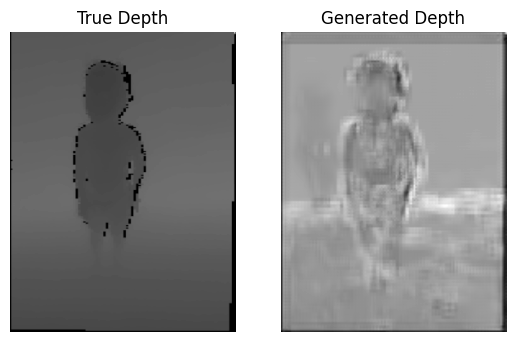

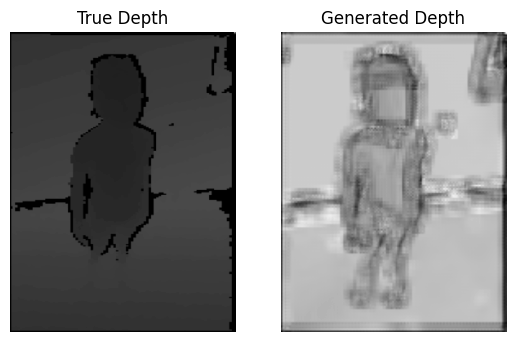

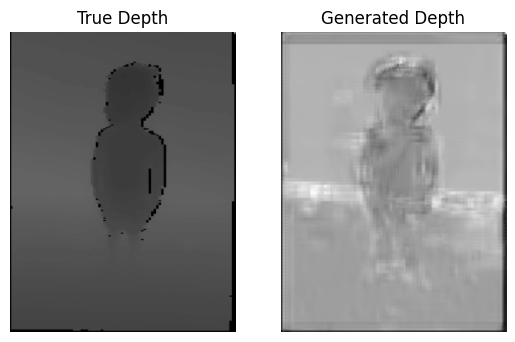

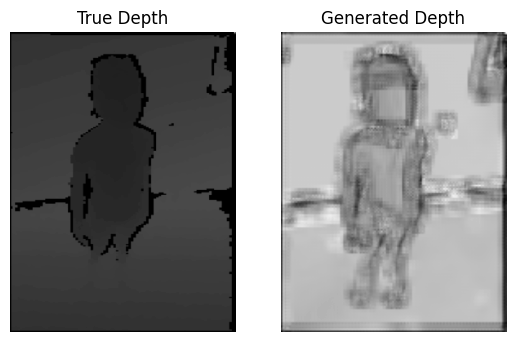

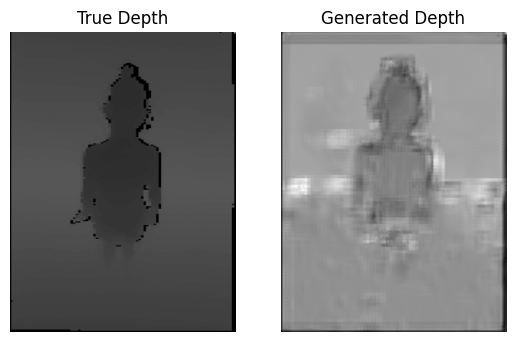

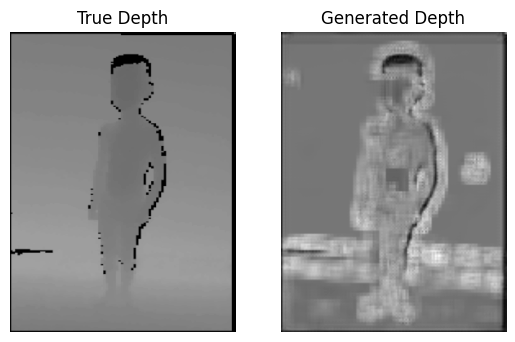

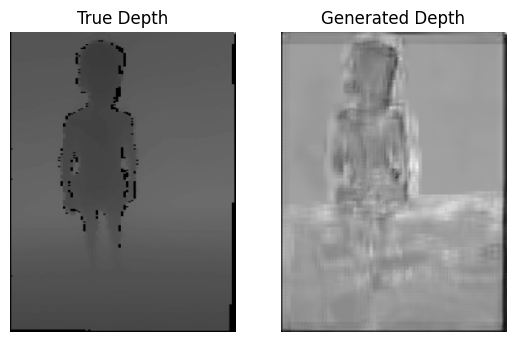

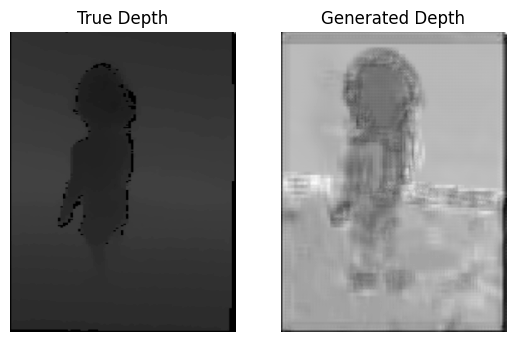

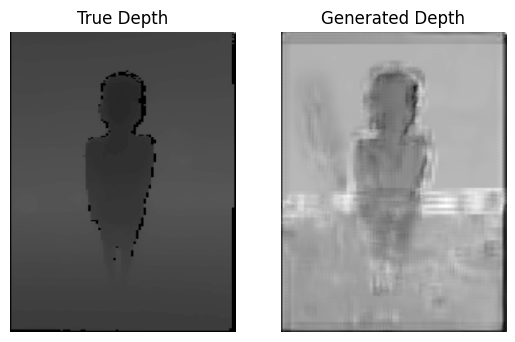

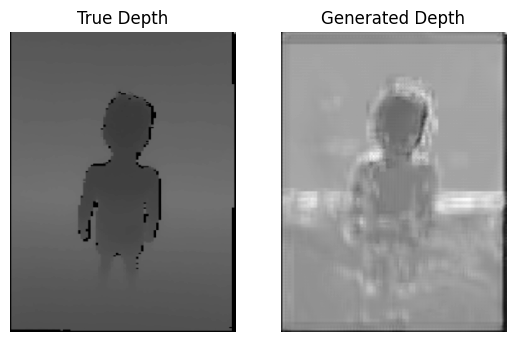

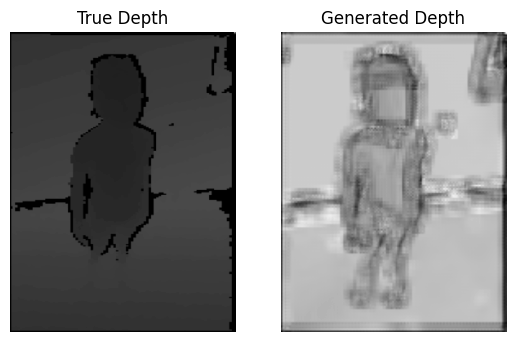

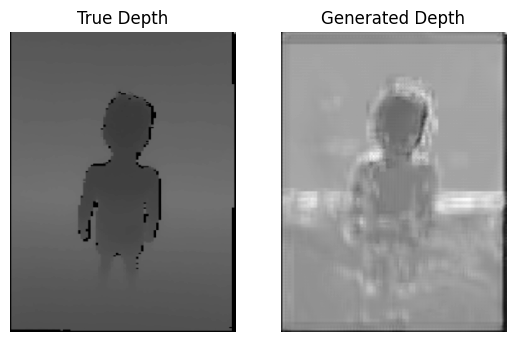

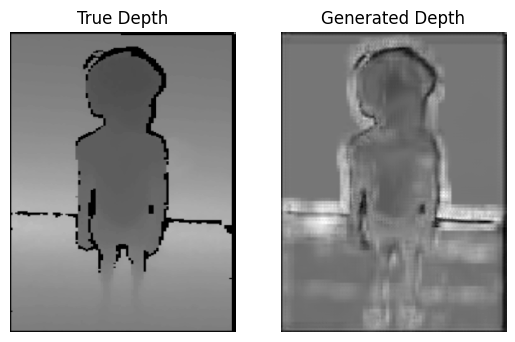

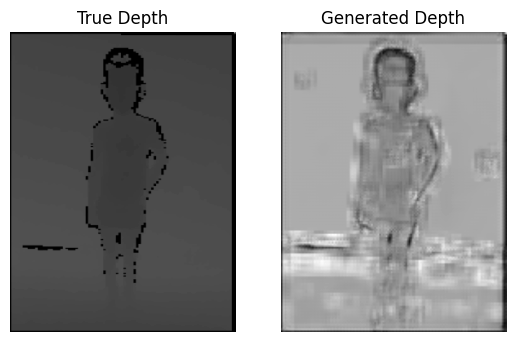

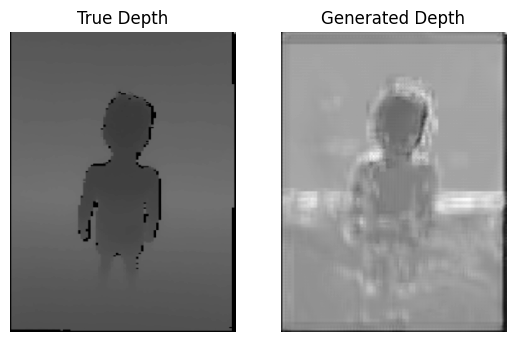

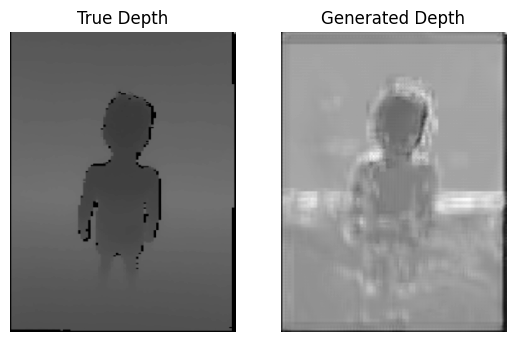

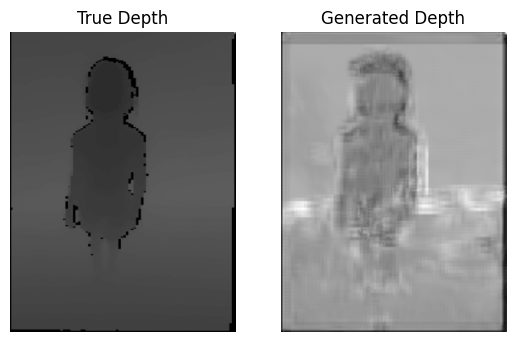

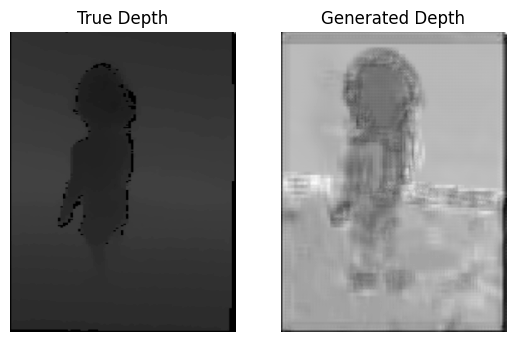

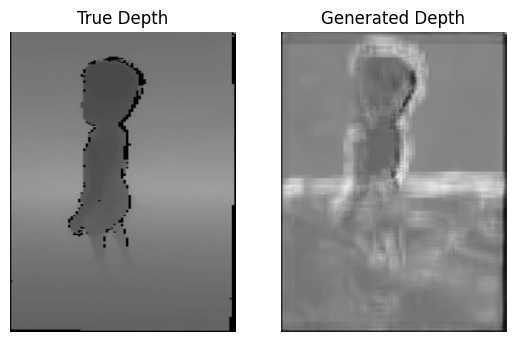

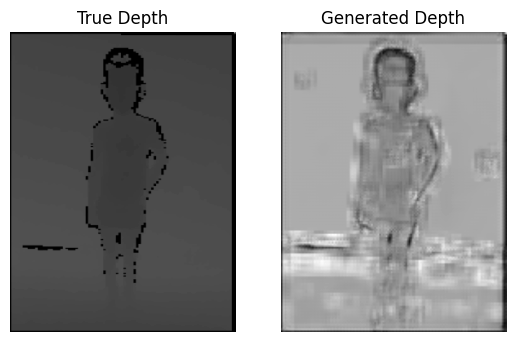

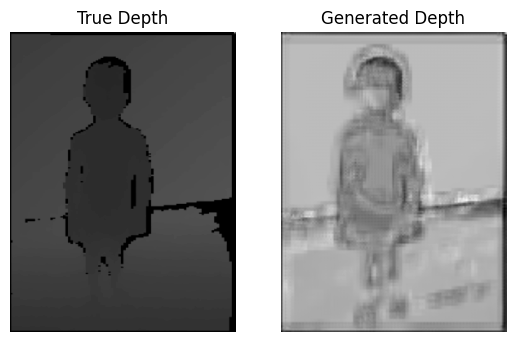

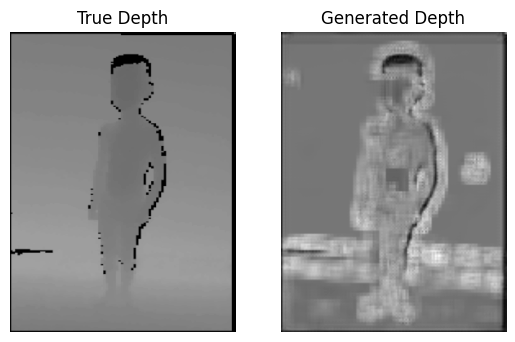

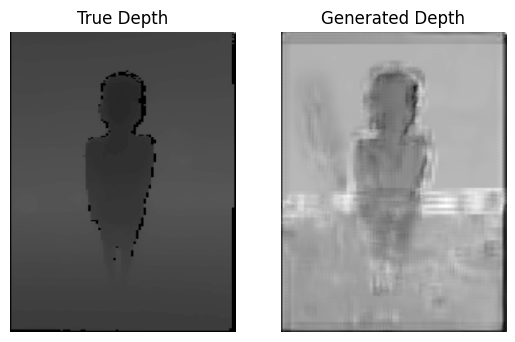

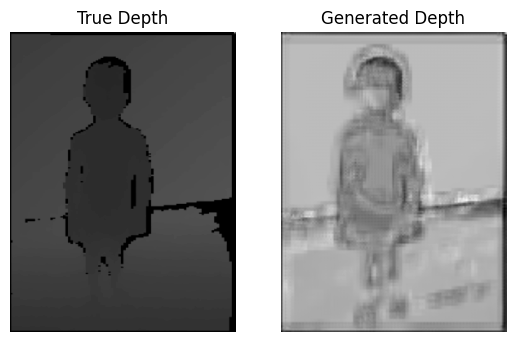

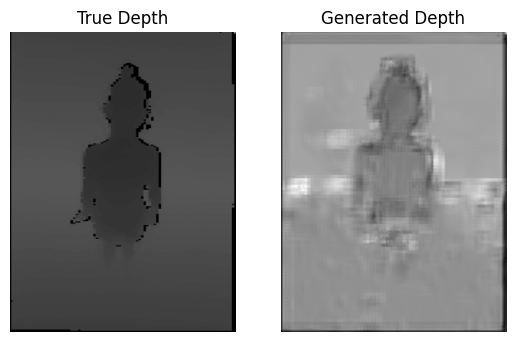

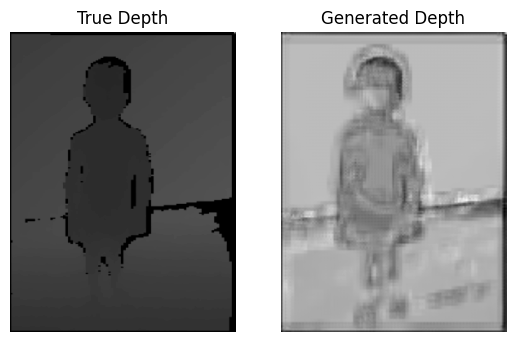

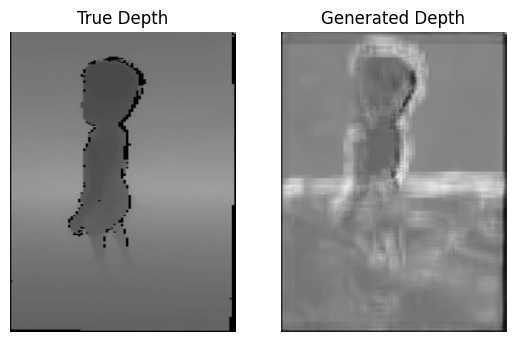

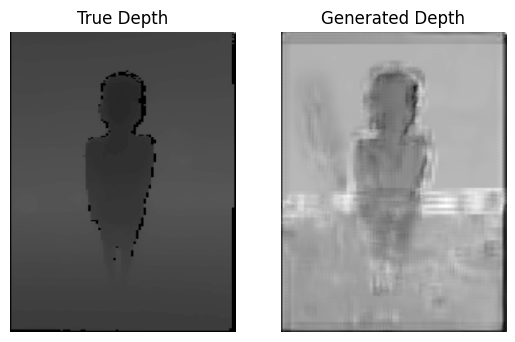

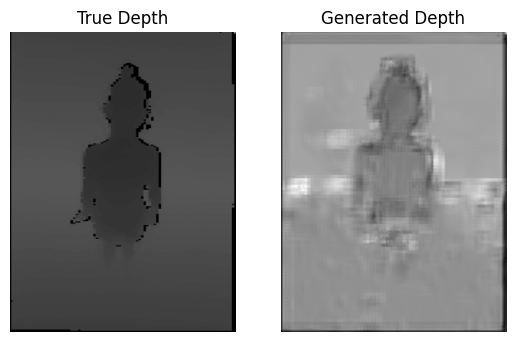

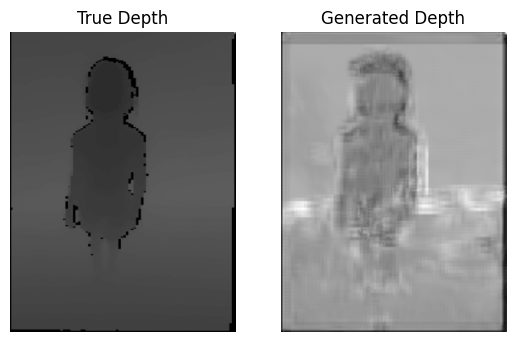

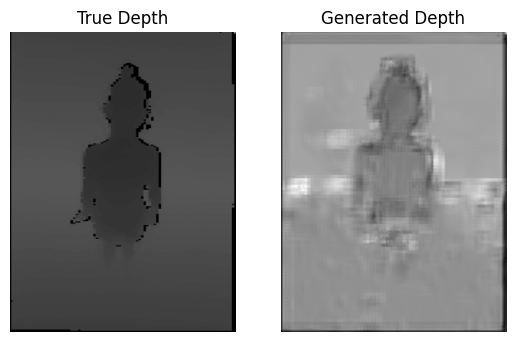

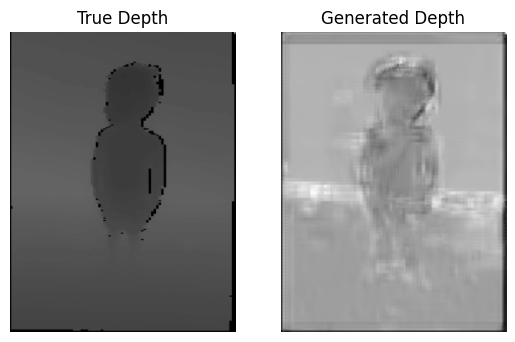

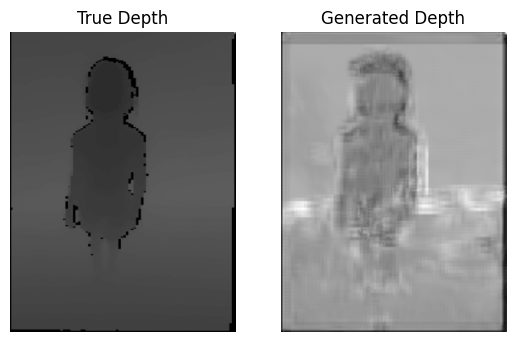

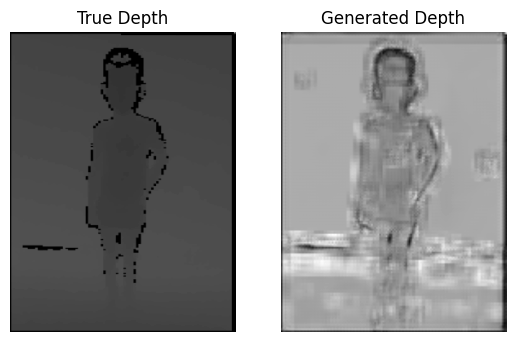

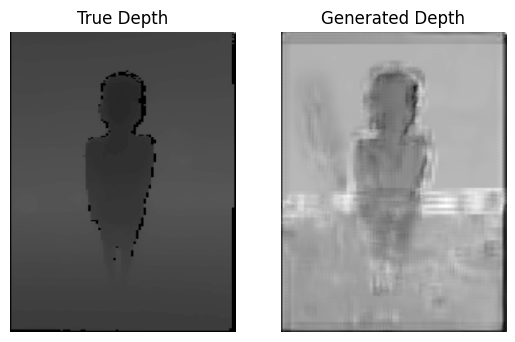

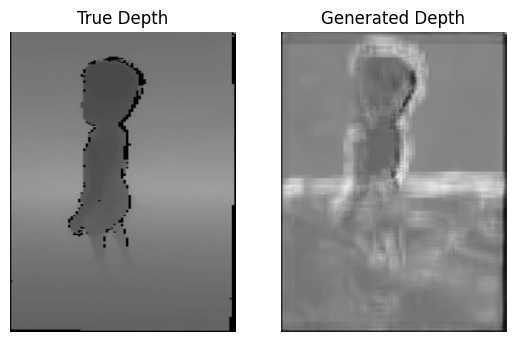

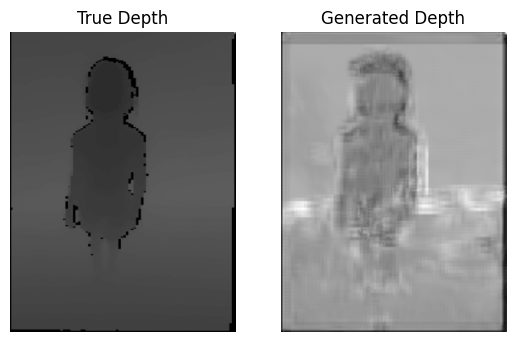

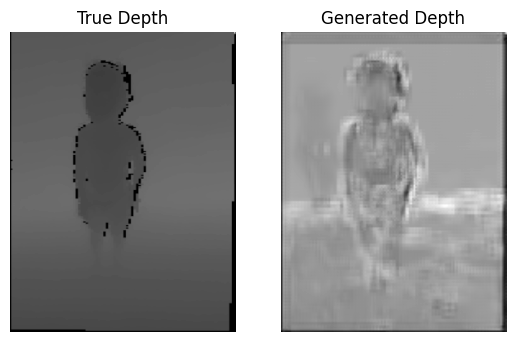

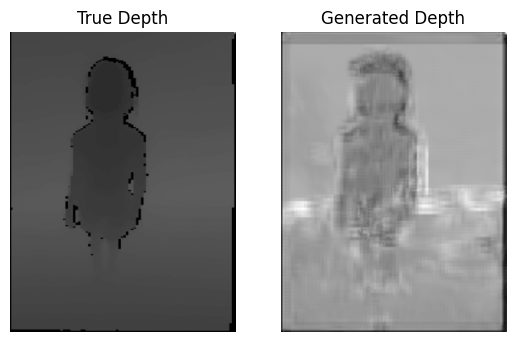

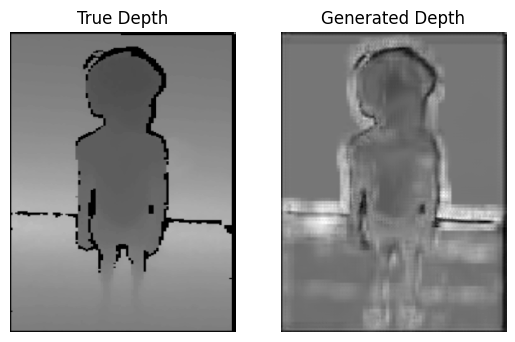

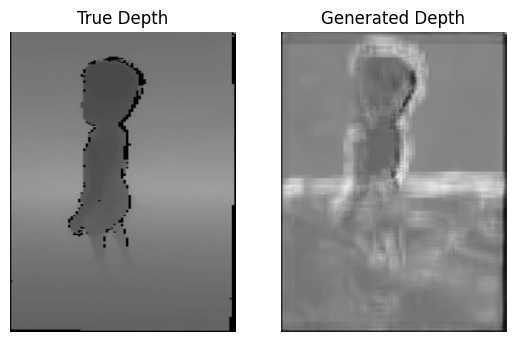

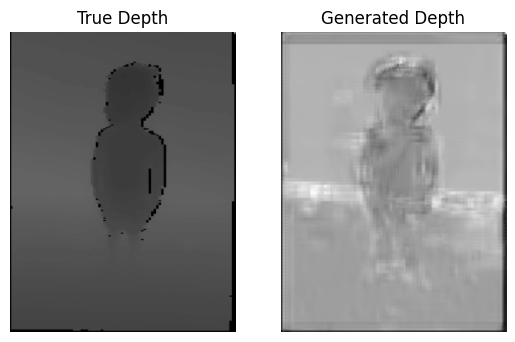

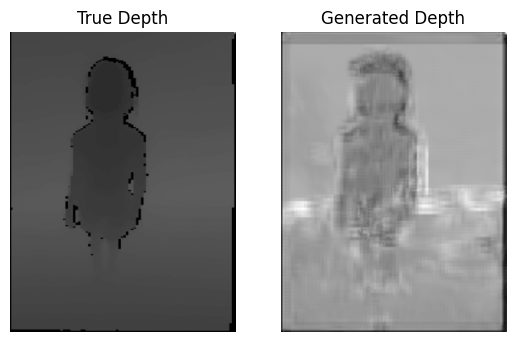

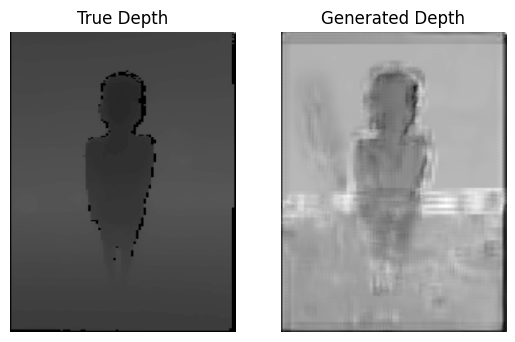

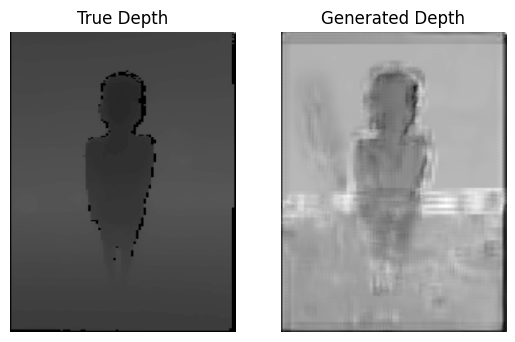

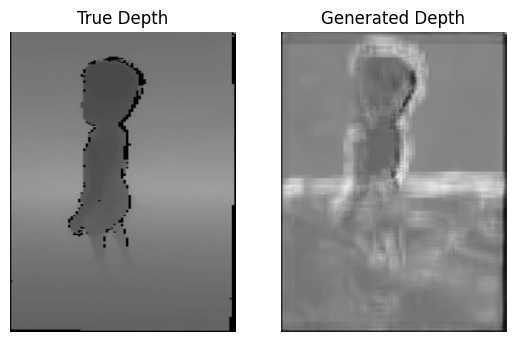

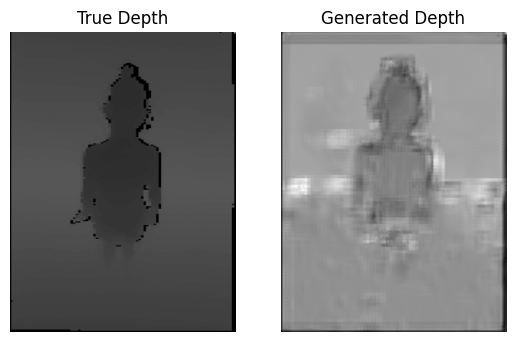

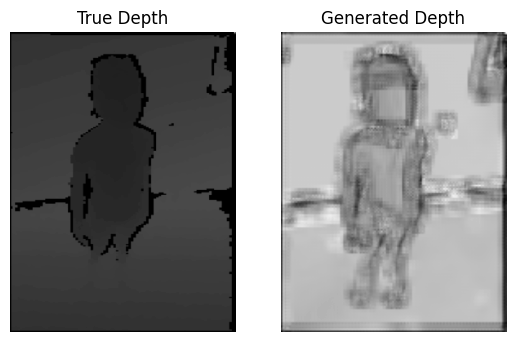

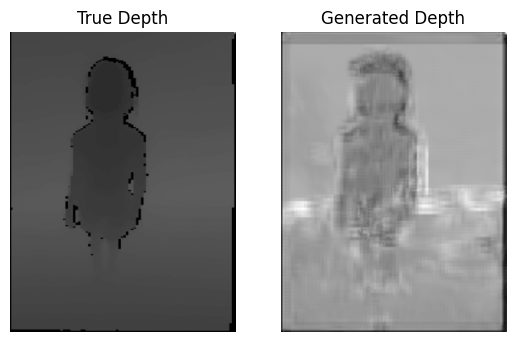

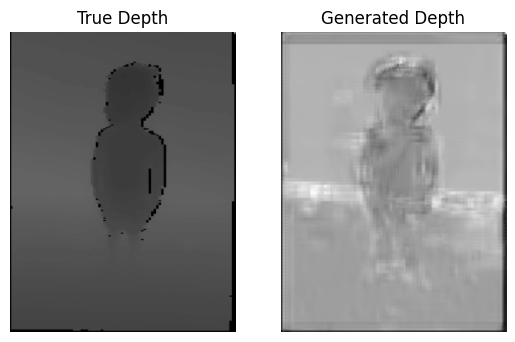

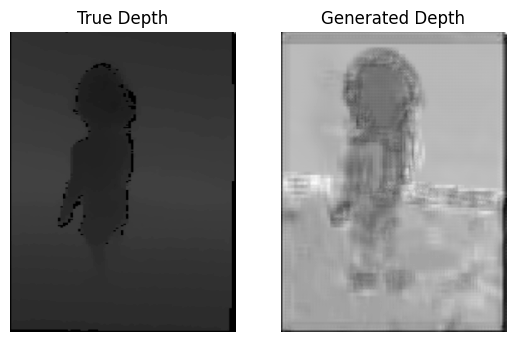

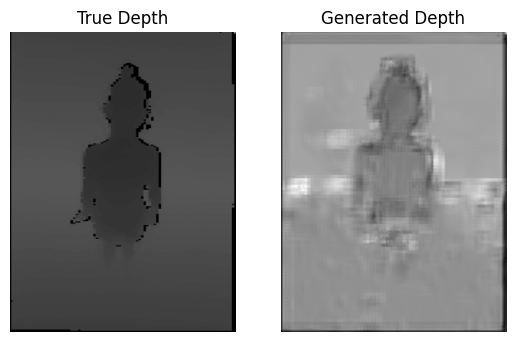

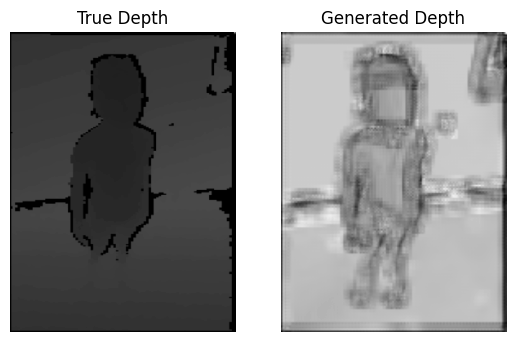

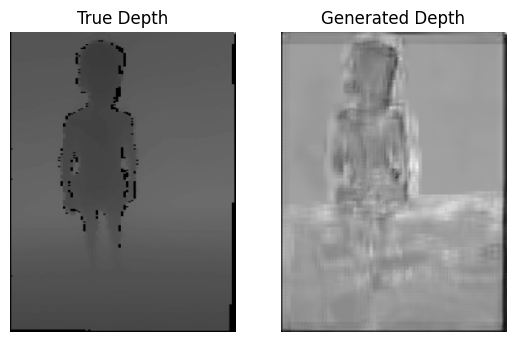

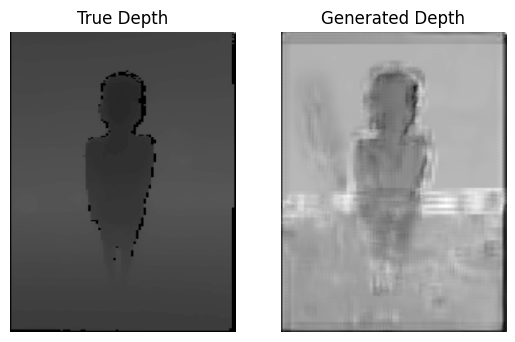

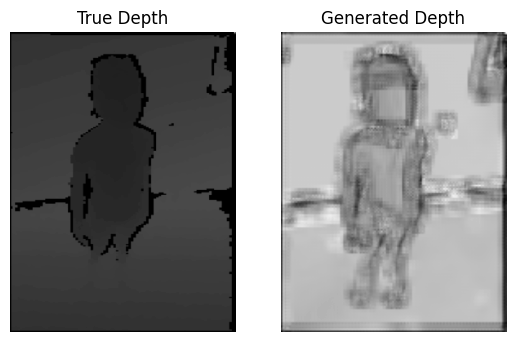

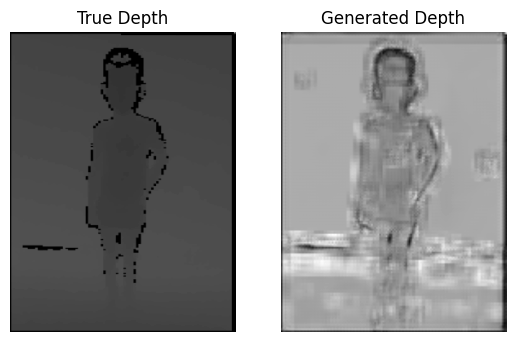

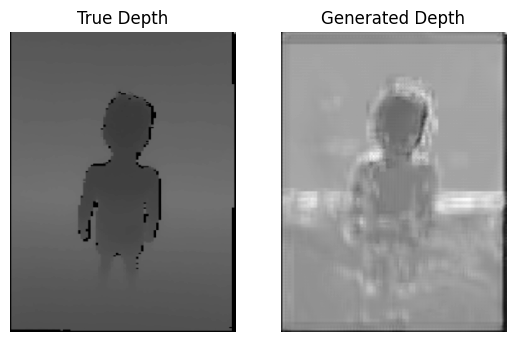

In [14]:
import matplotlib.pyplot as plt

# Validation
model.eval()

with torch.no_grad():
    for rgb_val, depth_val in val_loader:
        rgb_val = rgb_val.to(device)
        depth_val = depth_val.to(device)

        val_output = model(rgb_val)

        # Resize output tensor to match the size of the target tensor
        val_output = nn.functional.interpolate(val_output, size=depth_val.shape[2:], mode='bilinear', align_corners=False)

        # Convert tensors to numpy arrays
        depth_val = depth_val.cpu().numpy()
        val_output = val_output.cpu().numpy()

        # Display the depth maps
        for i in range(depth_val.shape[0]):
            fig, axes = plt.subplots(1, 2)
            axes[0].imshow(depth_val[i, 0], cmap='gray')
            axes[0].set_title('True Depth')
            axes[0].axis('off')
            axes[1].imshow(val_output[i, 0], cmap='gray')
            axes[1].set_title('Generated Depth')
            axes[1].axis('off')
            plt.show()